In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import shap
import warnings
shap.initjs()
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定するよ
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

### シーズナル成分のみ取り出してProphetで予測してみる

In [5]:
def rmse(y_true, y_pred):

    return np.sqrt(mse(y_true, y_pred))

In [6]:
df = pd.read_csv('train_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)
df_test = pd.read_csv('test_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)


def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df = format_date_time(df)
df_test = format_date_time(df_test)


In [7]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
target_names = ['CO', 'C6H6', 'NOx']
features = df.columns.to_list()
features.remove('date_time')

for i in targets:
    features.remove(i)

In [8]:
def targets_stl(df):

    for i in range(3):

        stl = STL(df[targets[i]].values, period=24, robust=True)
        stl_series = stl.fit()

        df[targets[i]] = stl_series.seasonal
    
    return df


def features_stl(df):

    for i in tqdm(range(len(features))):

        stl = STL(df[features[i]].values, period=24, robust=True)
        stl_series = stl.fit()
    
        df[features[i]] = stl_series.seasonal
    
    return df


df_seasonal = df.copy()

df_seasonal = targets_stl(df_seasonal)
df_seasonal = features_stl(df_seasonal)

100%|██████████| 129/129 [01:00<00:00,  2.14it/s]


シーズナル成分のグラフ

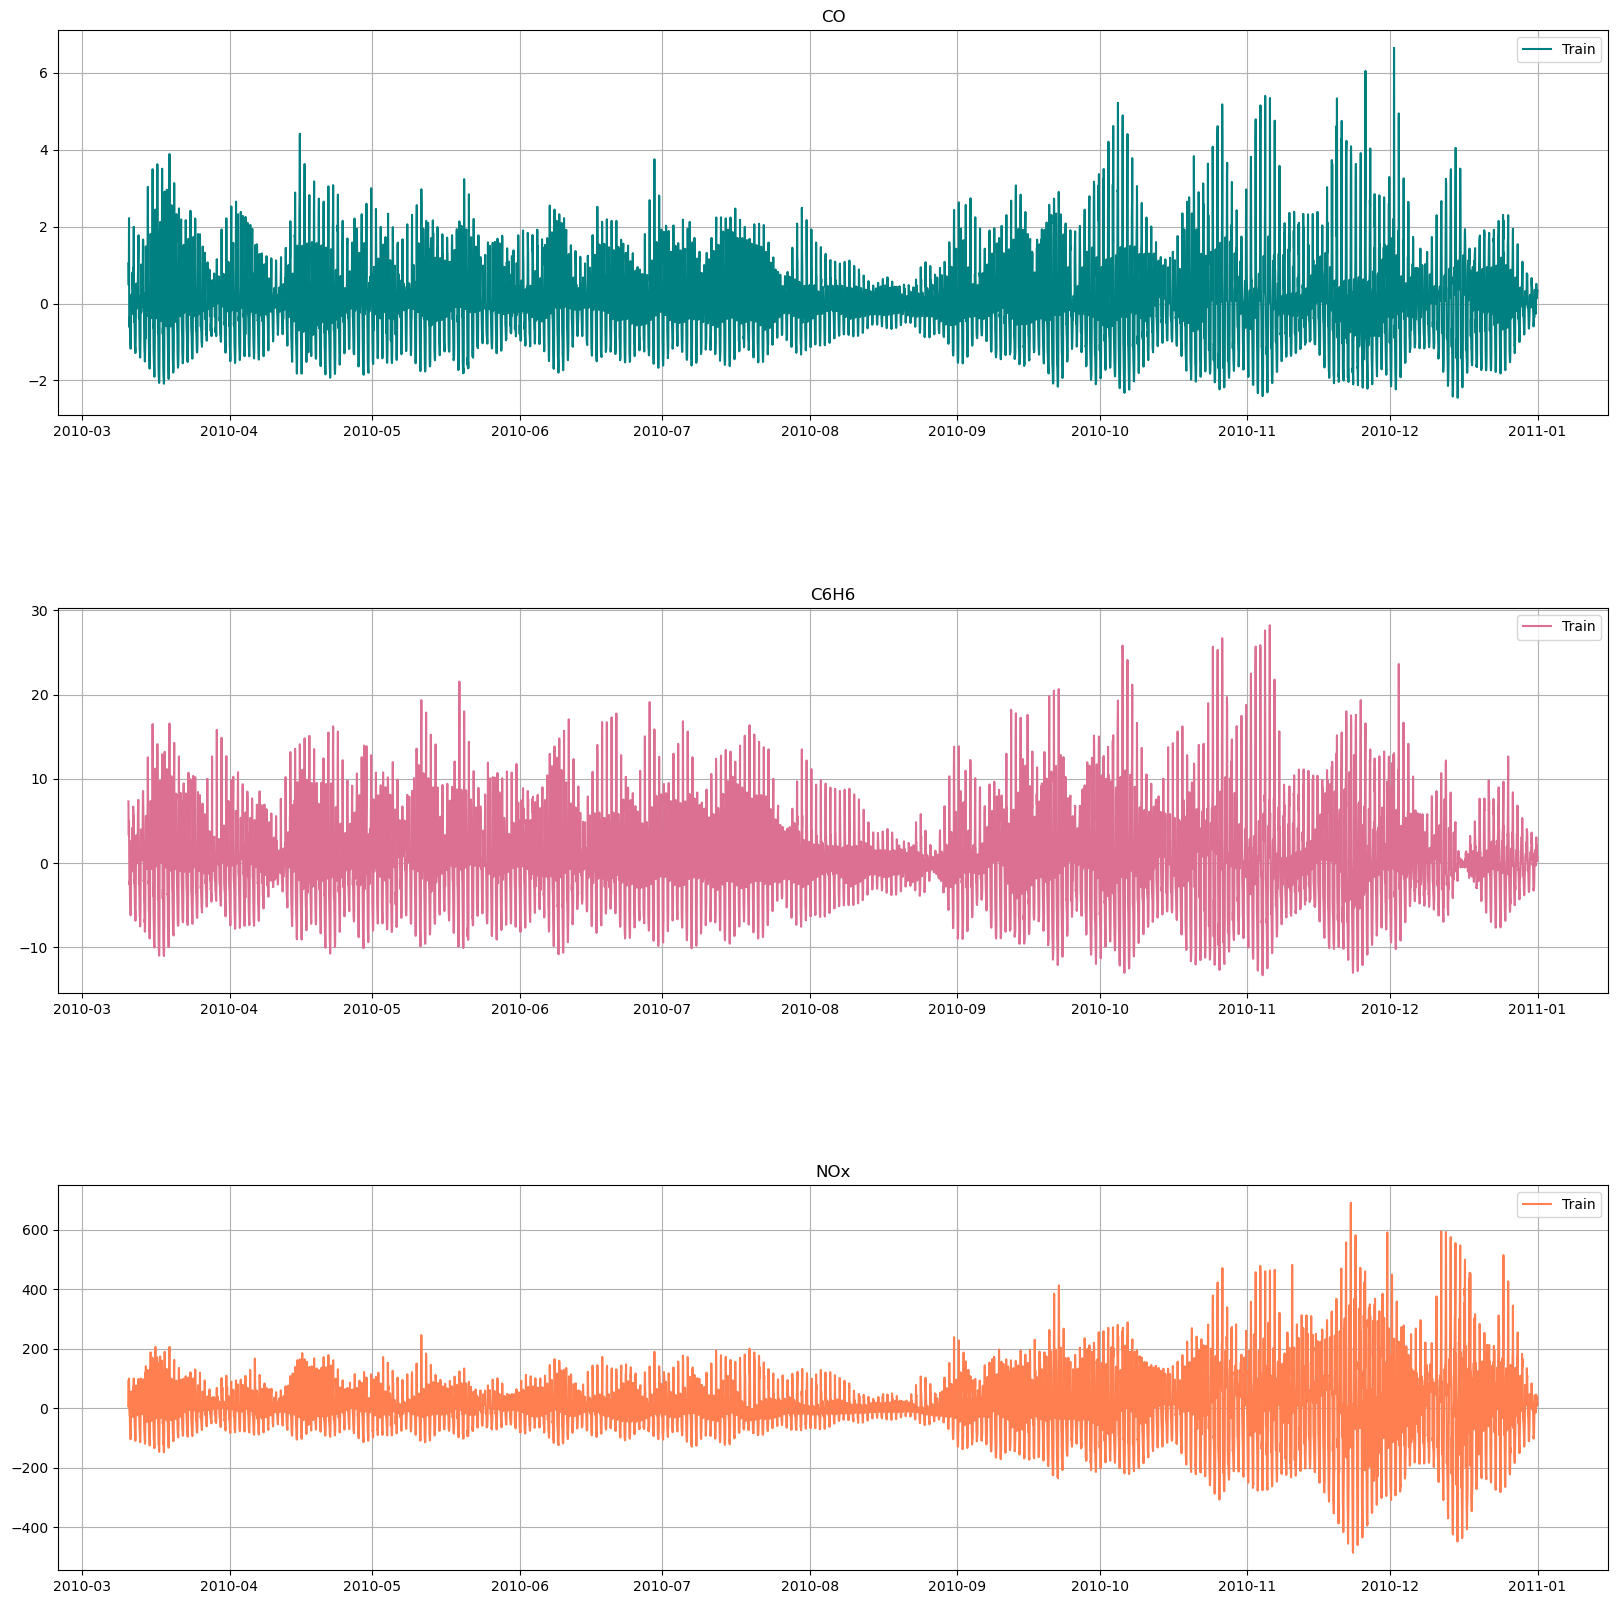

In [9]:
colors = ['teal', 'palevioletred', 'coral']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    axs[i].plot(df_seasonal['date_time'], df_seasonal[targets[i]], color=colors[i], label='Train')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

In [10]:
df_seasonal_CO = df_seasonal.drop([targets[1], targets[2]], axis=1)
df_seasonal_C6H6 = df_seasonal.drop([targets[0], targets[2]], axis=1)
df_seasonal_NOx = df_seasonal.drop([targets[0], targets[1]], axis=1)

df_seasonal_CO = df_seasonal_CO.rename(columns={'date_time': 'ds', targets[0]: 'y'})
df_seasonal_C6H6 = df_seasonal_C6H6.rename(columns={'date_time': 'ds', targets[1]: 'y'})
df_seasonal_NOx = df_seasonal_NOx.rename(columns={'date_time': 'ds', targets[2]: 'y'})

df_seasonal_CO_train, df_seasonal_CO_val = train_test_split(df_seasonal_CO, test_size=0.2, shuffle=False)
df_seasonal_C6H6_train, df_seasonal_C6H6_val = train_test_split(df_seasonal_C6H6, test_size=0.2, shuffle=False)
df_seasonal_NOx_train, df_seasonal_NOx_val = train_test_split(df_seasonal_NOx, test_size=0.2, shuffle=False)

In [11]:
model_CO = Prophet()

for i in tqdm(range(len(features))):

    model_CO.add_regressor(features[i])


model_C6H6 = Prophet()

for i in tqdm(range(len(features))):

    model_C6H6.add_regressor(features[i])


model_NOx = Prophet()

for i in tqdm(range(len(features))):

    model_NOx.add_regressor(features[i])

100%|██████████| 129/129 [00:00<00:00, 376000.85it/s]


In [12]:
model_CO.fit(df_seasonal_CO_train)
model_C6H6.fit(df_seasonal_C6H6_train)
model_NOx.fit(df_seasonal_NOx_train)

18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:43 - cmdstanpy - INFO - Chain [1] done processing
18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:46 - cmdstanpy - INFO - Chain [1] done processing
18:50:47 - cmdstanpy - INFO - Chain [1] start processing
18:50:48 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
pred_val_CO = model_CO.predict(df_seasonal_CO_val)
pred_val_C6H6 = model_C6H6.predict(df_seasonal_C6H6_val)
pred_val_NOx = model_NOx.predict(df_seasonal_NOx_val)

結果：デフォルトパラメーター。NOxが良くない。

In [14]:
# 負の値を含むのでRMSEで評価します
rmse_CO = rmse(df_seasonal_CO_val.y, pred_val_CO.yhat)
rmse_C6H6 = rmse(df_seasonal_C6H6_val.y, pred_val_C6H6.yhat)
rmse_NOx = rmse(df_seasonal_NOx_val.y, pred_val_NOx.yhat)

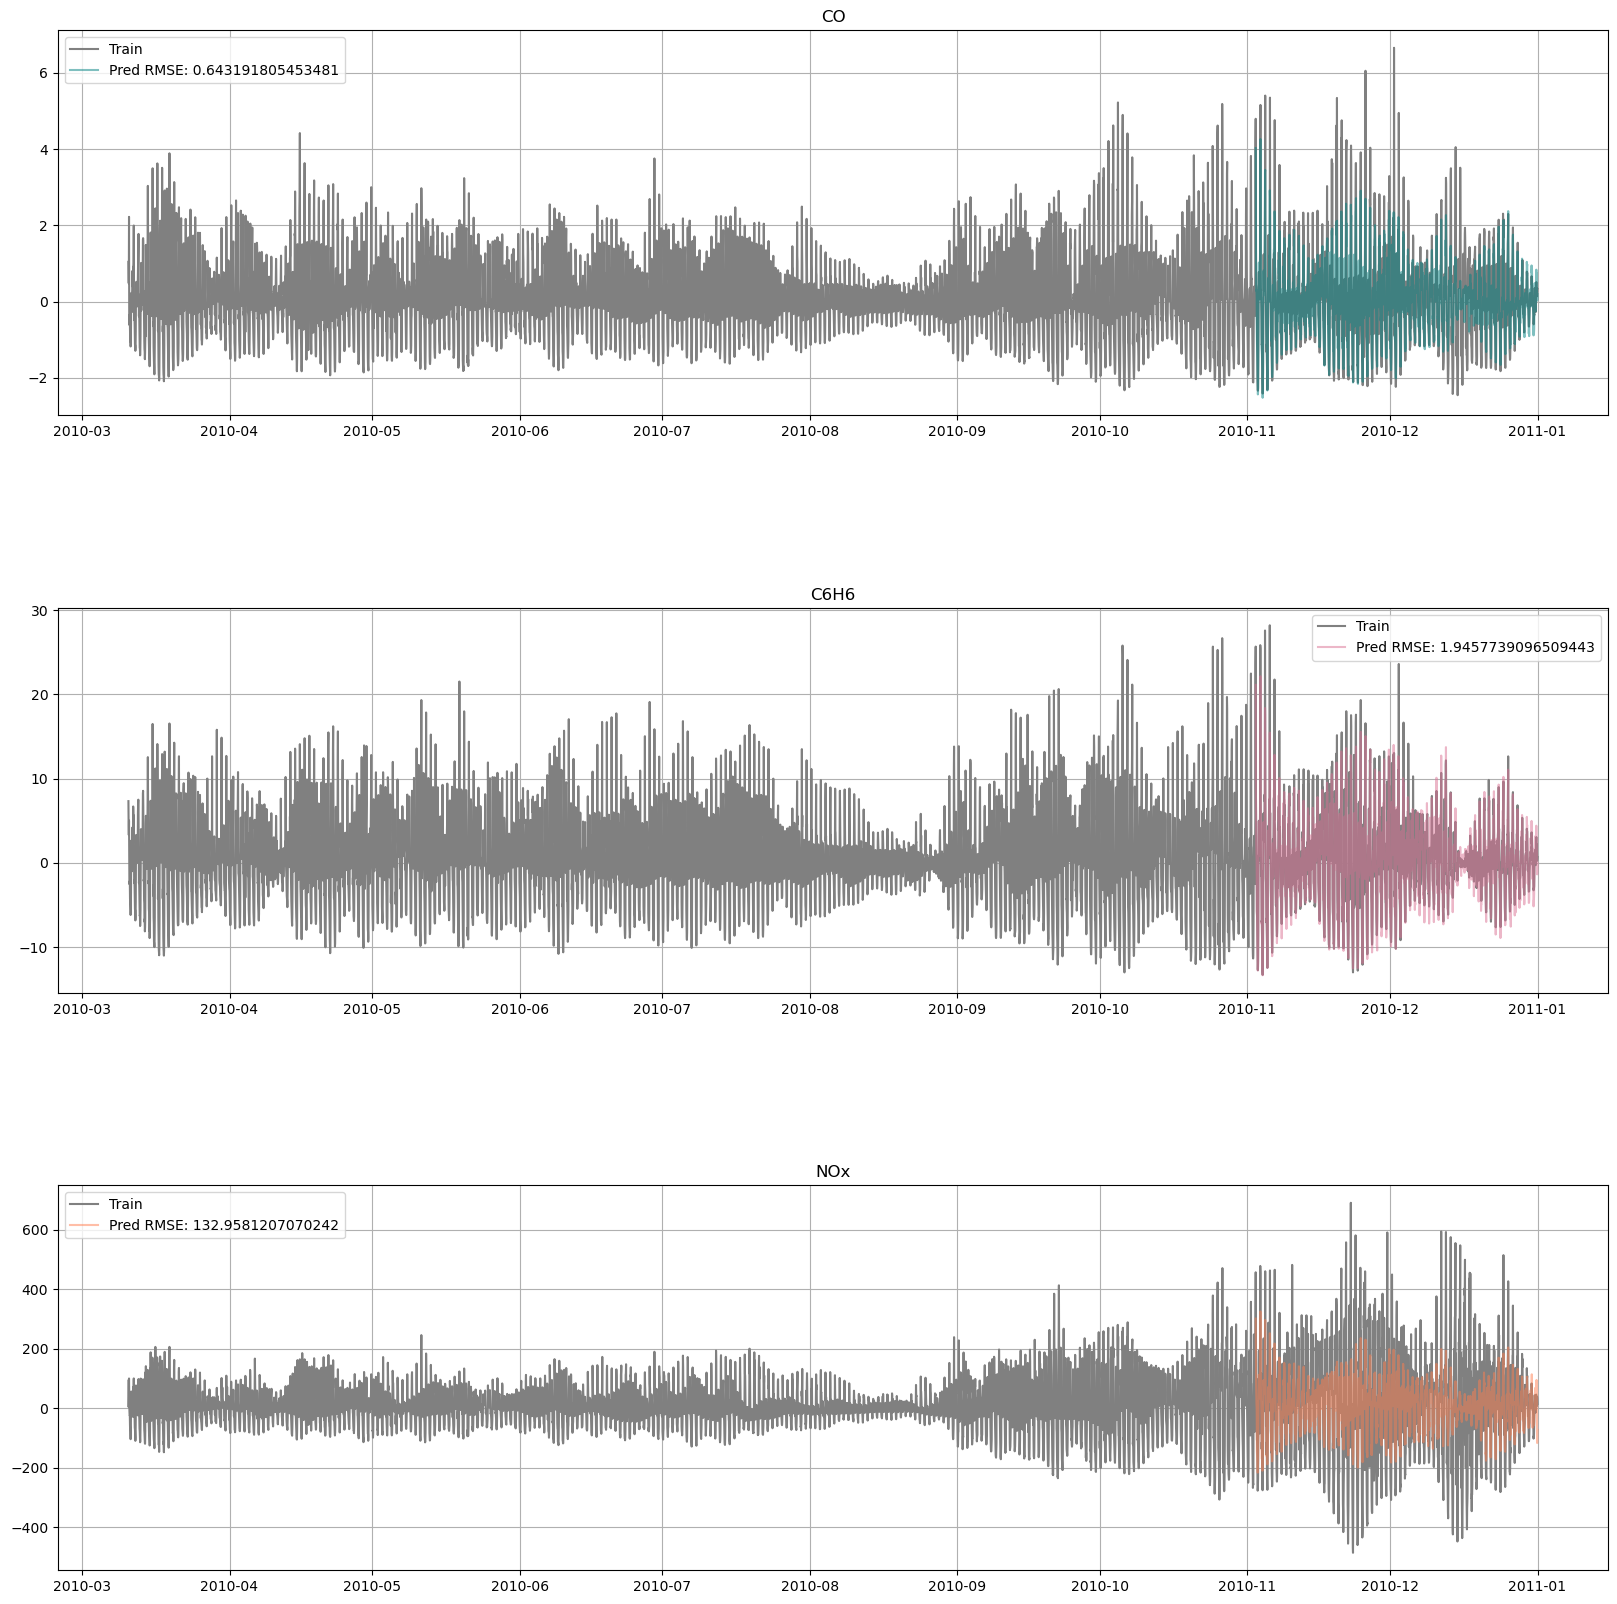

In [15]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'rmse_{target_names[i]}'
    name2 = f'df_seasonal_{target_names[i]}_val'
    name3 = f'pred_val_{target_names[i]}'

    axs[i].plot(df_seasonal['date_time'], df_seasonal[targets[i]], color='gray', label='Train')
    axs[i].plot(globals()[name2]['ds'], globals()[name3].iloc[:, -1], color=colors[i], alpha=0.5, label=f'Pred RMSE: {globals()[name1]}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

##### Optunaでパラメータ最適化

In [16]:
df_seasonal_CO_train['cap'] = int(np.max(df_seasonal_CO_train.y))
df_seasonal_CO_train['floor'] = int(np.min(df_seasonal_CO_train.y))
df_seasonal_CO_val['cap'] = int(np.max(df_seasonal_CO_train.y))
df_seasonal_CO_val['floor'] = int(np.min(df_seasonal_CO_train.y))

df_seasonal_C6H6_train['cap'] = int(np.max(df_seasonal_C6H6_train.y))
df_seasonal_C6H6_train['floor'] = int(np.min(df_seasonal_C6H6_train.y))
df_seasonal_C6H6_val['cap'] = int(np.max(df_seasonal_C6H6_train.y))
df_seasonal_C6H6_val['floor'] = int(np.min(df_seasonal_C6H6_train.y))

df_seasonal_NOx_train['cap'] = int(np.max(df_seasonal_NOx_train.y))
df_seasonal_NOx_train['floor'] = int(np.min(df_seasonal_NOx_train.y))
df_seasonal_NOx_val['cap'] = int(np.max(df_seasonal_NOx_train.y))
df_seasonal_NOx_val['floor'] = int(np.min(df_seasonal_NOx_train.y))

In [17]:
def objective_variable(train,valid):

    cap = int(np.max(train.y))
    floor = int(np.min(train.y))

    def objective(trial):
            params = {
                    'changepoint_range' : trial.suggest_discrete_uniform('changepoint_range',0.8,0.95,0.001),
                    'n_changepoints' : trial.suggest_int('n_changepoints',20,35),
                    'changepoint_prior_scale' : trial.suggest_discrete_uniform('changepoint_prior_scale',0.001,0.5,0.001),
                    'seasonality_prior_scale' : trial.suggest_discrete_uniform('seasonality_prior_scale',1,25,0.5),
                     }
            # fit_model
            model = Prophet(
                    changepoint_range = params['changepoint_prior_scale'],
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')
            
            for i in range(len(features)):
                 model.add_regressor(features[i])

            train['cap'] = cap
            train['floor'] = floor

            model.fit(train)

            valid['cap'] = cap
            valid['floor'] = floor           

            forecast = model.predict(valid)

            val_rmse = rmse(valid.y, forecast.yhat)
            return val_rmse

    return objective


def get_parameter(train,valid):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123), direction='minimize')
    study.optimize(objective_variable(train,valid), timeout=600)

    return study

In [18]:
study_CO = get_parameter(df_seasonal_CO_train, df_seasonal_CO_val)

18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing
18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing
18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:59 - cmdstanpy - INFO - Chain [1] done processing
18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing
18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1]

In [19]:
study_C6H6 = get_parameter(df_seasonal_C6H6_train, df_seasonal_C6H6_val)

19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:59 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] done processing
19:01:18 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:37 - cmdstanpy - INFO - Chain [1] done processing
19:01:45 - cmdstanpy - INFO - Chain [1] start processing
19:01:49 - cmdstanpy - INFO - Chain [1] done processing
19:01:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:15 - cmdstanpy - INFO - Chain [1] done processing
19:02:22 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing
19:02:34 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1]

In [20]:
study_NOx = get_parameter(df_seasonal_NOx_train, df_seasonal_NOx_val)

19:31:57 - cmdstanpy - INFO - Chain [1] start processing
19:35:02 - cmdstanpy - INFO - Chain [1] done processing
19:35:09 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing
19:35:22 - cmdstanpy - INFO - Chain [1] start processing
19:35:28 - cmdstanpy - INFO - Chain [1] done processing
19:35:35 - cmdstanpy - INFO - Chain [1] start processing
19:35:38 - cmdstanpy - INFO - Chain [1] done processing
19:35:46 - cmdstanpy - INFO - Chain [1] start processing
19:35:50 - cmdstanpy - INFO - Chain [1] done processing
19:35:58 - cmdstanpy - INFO - Chain [1] start processing
19:36:02 - cmdstanpy - INFO - Chain [1] done processing
19:36:10 - cmdstanpy - INFO - Chain [1] start processing
19:36:15 - cmdstanpy - INFO - Chain [1] done processing
19:36:23 - cmdstanpy - INFO - Chain [1] start processing
19:36:26 - cmdstanpy - INFO - Chain [1] done processing
19:36:34 - cmdstanpy - INFO - Chain [1] start processing
19:36:39 - cmdstanpy - INFO - Chain [1]

In [21]:
model_CO_2 = Prophet(changepoint_range = study_CO.best_params['changepoint_prior_scale'],
                    n_changepoints = study_CO.best_params['n_changepoints'],
                    changepoint_prior_scale = study_CO.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_CO.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_CO_2.add_regressor(features[i])

df_seasonal_CO_train['cap'] = int(np.max(df_seasonal_CO_train.y))
df_seasonal_CO_train['floor'] = int(np.min(df_seasonal_CO_train.y))

model_CO_2.fit(df_seasonal_CO_train)

df_seasonal_CO_val['cap'] = int(np.max(df_seasonal_CO_train.y))
df_seasonal_CO_val['floor'] = int(np.min(df_seasonal_CO_train.y))

pred_val_CO_2 = model_CO_2.predict(df_seasonal_CO_val)

19:42:09 - cmdstanpy - INFO - Chain [1] start processing
19:42:16 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
model_C6H6_2 = Prophet(changepoint_range = study_C6H6.best_params['changepoint_prior_scale'],
                    n_changepoints = study_C6H6.best_params['n_changepoints'],
                    changepoint_prior_scale = study_C6H6.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_C6H6.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_C6H6_2.add_regressor(features[i])

df_seasonal_C6H6_train['cap'] = int(np.max(df_seasonal_C6H6_train.y))
df_seasonal_C6H6_train['floor'] = int(np.min(df_seasonal_C6H6_train.y))

model_C6H6_2.fit(df_seasonal_C6H6_train)

df_seasonal_C6H6_val['cap'] = int(np.max(df_seasonal_C6H6_train.y))
df_seasonal_C6H6_val['floor'] = int(np.min(df_seasonal_C6H6_train.y))

pred_val_C6H6_2 = model_C6H6_2.predict(df_seasonal_C6H6_val)

19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:30 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
model_NOx_2 = Prophet(changepoint_range = study_NOx.best_params['changepoint_prior_scale'],
                    n_changepoints = study_NOx.best_params['n_changepoints'],
                    changepoint_prior_scale = study_NOx.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_NOx.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_NOx_2.add_regressor(features[i])

df_seasonal_NOx_train['cap'] = int(np.max(df_seasonal_NOx_train.y))
df_seasonal_NOx_train['floor'] = int(np.min(df_seasonal_NOx_train.y))

model_NOx_2.fit(df_seasonal_NOx_train)

df_seasonal_NOx_val['cap'] = int(np.max(df_seasonal_NOx_train.y))
df_seasonal_NOx_val['floor'] = int(np.min(df_seasonal_NOx_train.y))

pred_val_NOx_2 = model_NOx_2.predict(df_seasonal_NOx_val)

19:42:39 - cmdstanpy - INFO - Chain [1] start processing
19:42:42 - cmdstanpy - INFO - Chain [1] done processing


結果大差なし

In [24]:
rmse_CO_2 = rmse(df_seasonal_CO_val.y, pred_val_CO_2.yhat)
rmse_C6H6_2 = rmse(df_seasonal_C6H6_val.y, pred_val_C6H6_2.yhat)
rmse_NOx_2 = rmse(df_seasonal_NOx_val.y, pred_val_NOx_2.yhat)

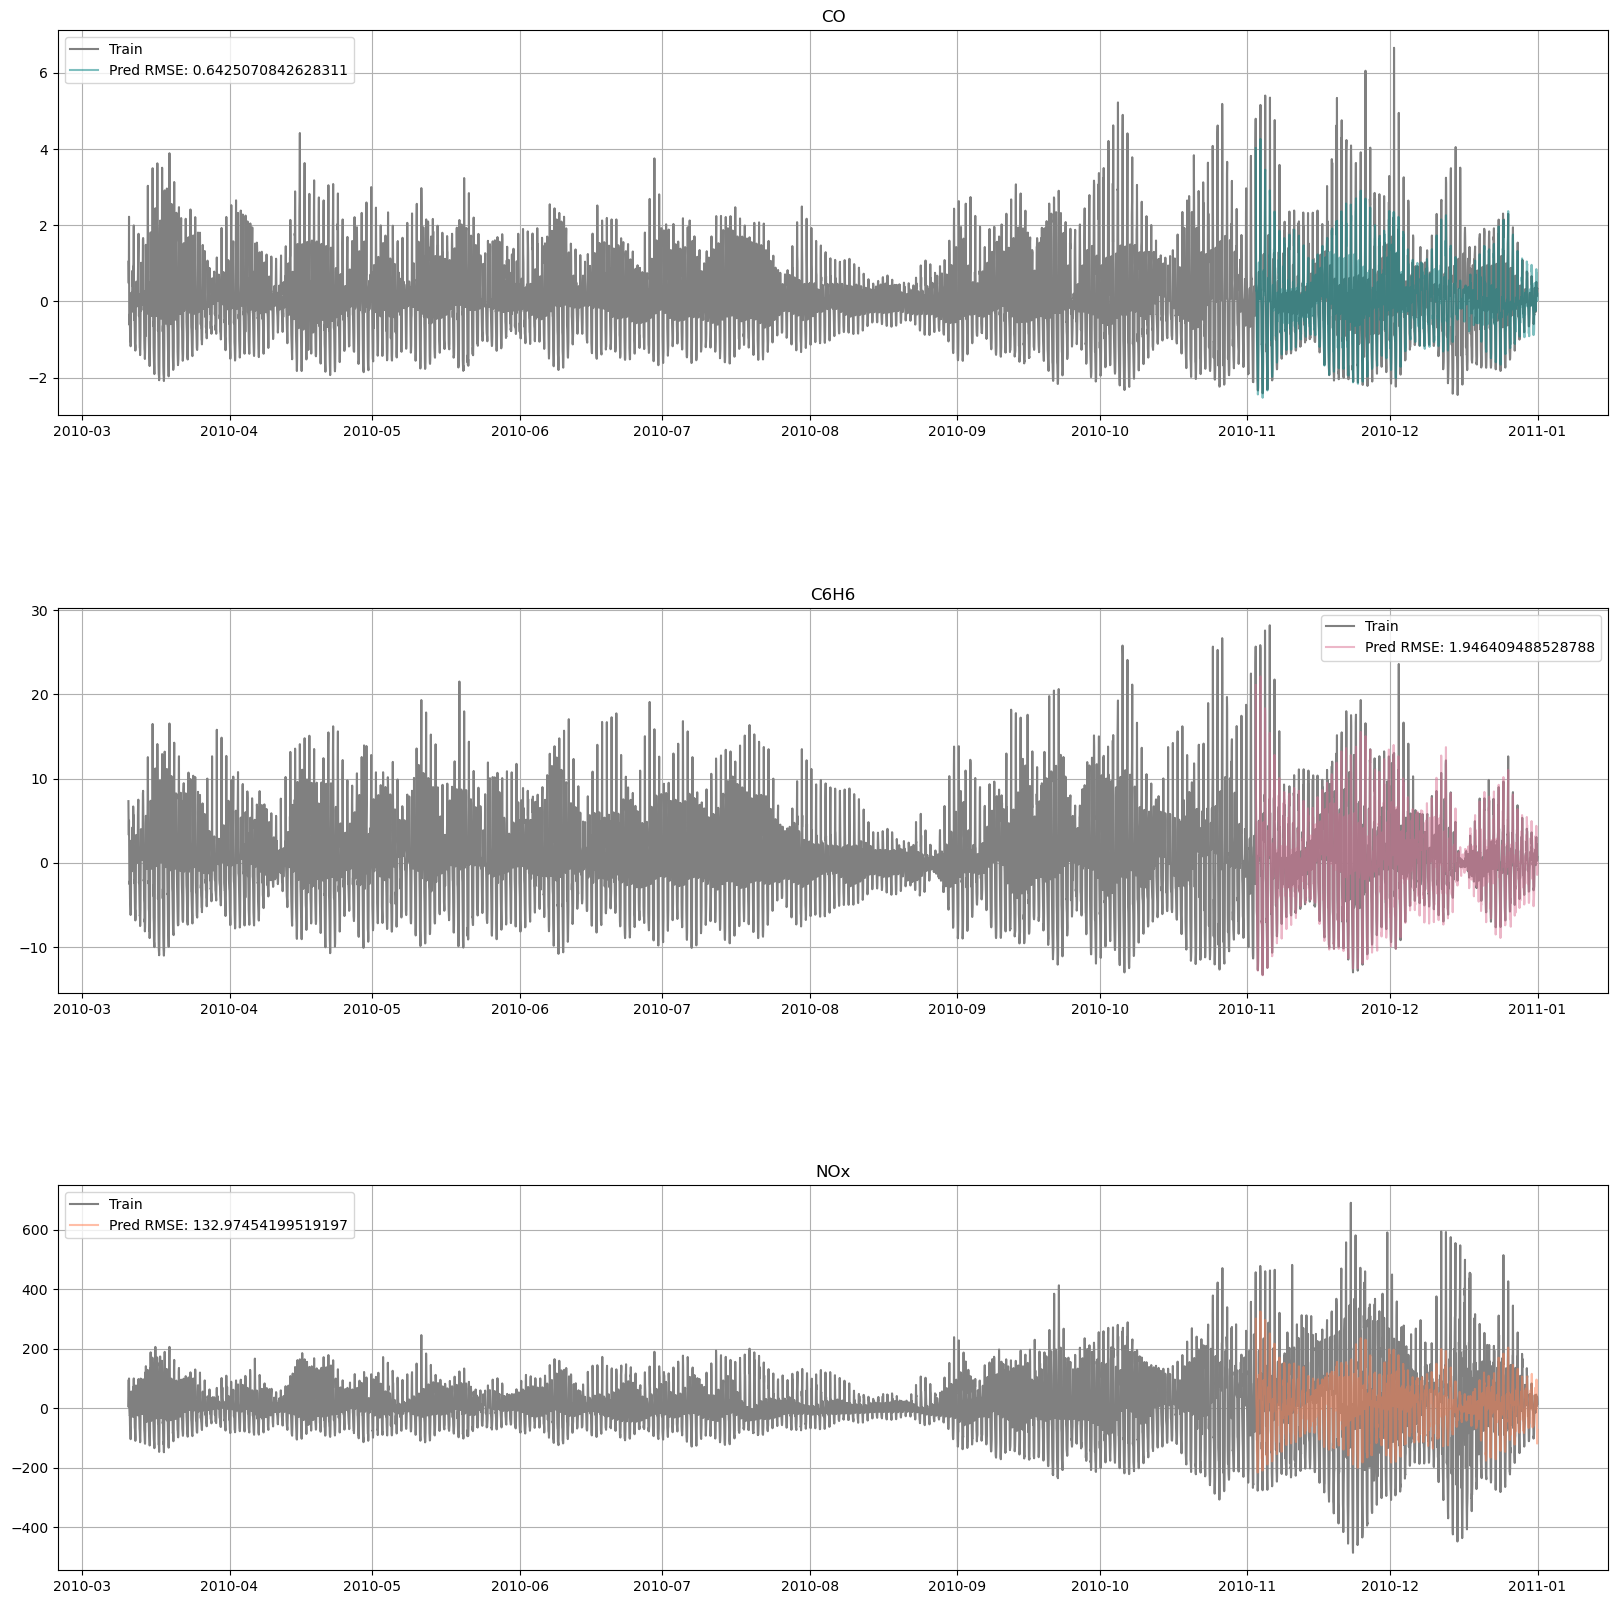

In [25]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'rmse_{target_names[i]}_2'
    name2 = f'df_seasonal_{target_names[i]}_val'
    name3 = f'pred_val_{target_names[i]}_2'

    axs[i].plot(df_seasonal['date_time'], df_seasonal[targets[i]], color='gray', label='Train')
    axs[i].plot(globals()[name2]['ds'], globals()[name3].iloc[:, -1], color=colors[i], alpha=0.5, label=f'Pred RMSE: {globals()[name1]}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

### シーズナル成分をlightGBMで予測してみる

In [26]:
categorical_features = ['day_of_week', 'working_hours']

df_seasonal_CO_train.set_index('ds', inplace=True)
df_seasonal_CO_val.set_index('ds', inplace=True)
train_y_CO = df_seasonal_CO_train['y']
train_x_CO = df_seasonal_CO_train.drop('y', axis=1)
val_y_CO = df_seasonal_CO_val['y']
val_x_CO = df_seasonal_CO_val.drop('y', axis=1)

df_seasonal_C6H6_train.set_index('ds', inplace=True)
df_seasonal_C6H6_val.set_index('ds', inplace=True)
train_y_C6H6 = df_seasonal_C6H6_train['y']
train_x_C6H6 = df_seasonal_C6H6_train.drop('y', axis=1)
val_y_C6H6 = df_seasonal_C6H6_val['y']
val_x_C6H6 = df_seasonal_C6H6_val.drop('y', axis=1)

df_seasonal_NOx_train.set_index('ds', inplace=True)
df_seasonal_NOx_val.set_index('ds', inplace=True)
train_y_NOx = df_seasonal_NOx_train['y']
train_x_NOx = df_seasonal_NOx_train.drop('y', axis=1)
val_y_NOx = df_seasonal_NOx_val['y']
val_x_NOx = df_seasonal_NOx_val.drop('y', axis=1)

In [27]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_CO, train_y_CO)
    lgb_valids = lgb.Dataset(val_x_CO, val_y_CO)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_CO = regressor.predict(val_x_CO)

    val_rmse = rmse(np.expm1(val_y_CO), np.expm1(lgb_pred_val_y_CO))
    
    return val_rmse

study_CO = optuna.create_study(direction='minimize')
study_CO.optimize(objective, timeout=300)

In [ ]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(train_x_CO, train_y_CO)
valids = lgb.Dataset(val_x_CO, val_y_CO)

model_lgb_CO = lgb.train(study_CO.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_CO = model_lgb_CO.predict(val_x_CO)
rmse_CO = rmse(val_y_CO, val_lgb_CO)

rmse_CO

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 127
[LightGBM] [Info] Start training from score -0.000058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

0.6953251021494805

In [ ]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
    lgb_valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_C6H6 = regressor.predict(val_x_C6H6)

    val_rmse = rmse(val_y_C6H6, lgb_pred_val_y_C6H6)
    
    return val_rmse

study_C6H6 = optuna.create_study(direction='minimize')
study_C6H6.optimize(objective, timeout=300)

In [ ]:
# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)

model_lgb_C6H6 = lgb.train(study_C6H6.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_C6H6 = model_lgb_C6H6.predict(val_x_C6H6)
rmse_C6H6 = rmse(val_y_C6H6, val_lgb_C6H6)

rmse_C6H6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 127
[LightGBM] [Info] Start training from score 0.000510
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

1.8087304241713964

In [ ]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_NOx, train_y_NOx)
    lgb_valids = lgb.Dataset(val_x_NOx, val_y_NOx)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_NOx = regressor.predict(val_x_NOx)

    val_rmse = rmse(val_y_NOx, lgb_pred_val_y_NOx)
    
    return val_rmse

study_NOx = optuna.create_study(direction='minimize')
study_NOx.optimize(objective, timeout=300)

In [ ]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(train_x_NOx, train_y_NOx)
valids = lgb.Dataset(val_x_NOx, val_y_NOx)

model_lgb_NOx = lgb.train(study_NOx.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_NOx = model_lgb_NOx.predict(val_x_NOx)
rmse_NOx = rmse(val_y_NOx, val_lgb_NOx)

rmse_NOx

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 127
[LightGBM] [Info] Start training from score 0.009177


128.52816875576838

##### 結果：Prophetよりちょっといい

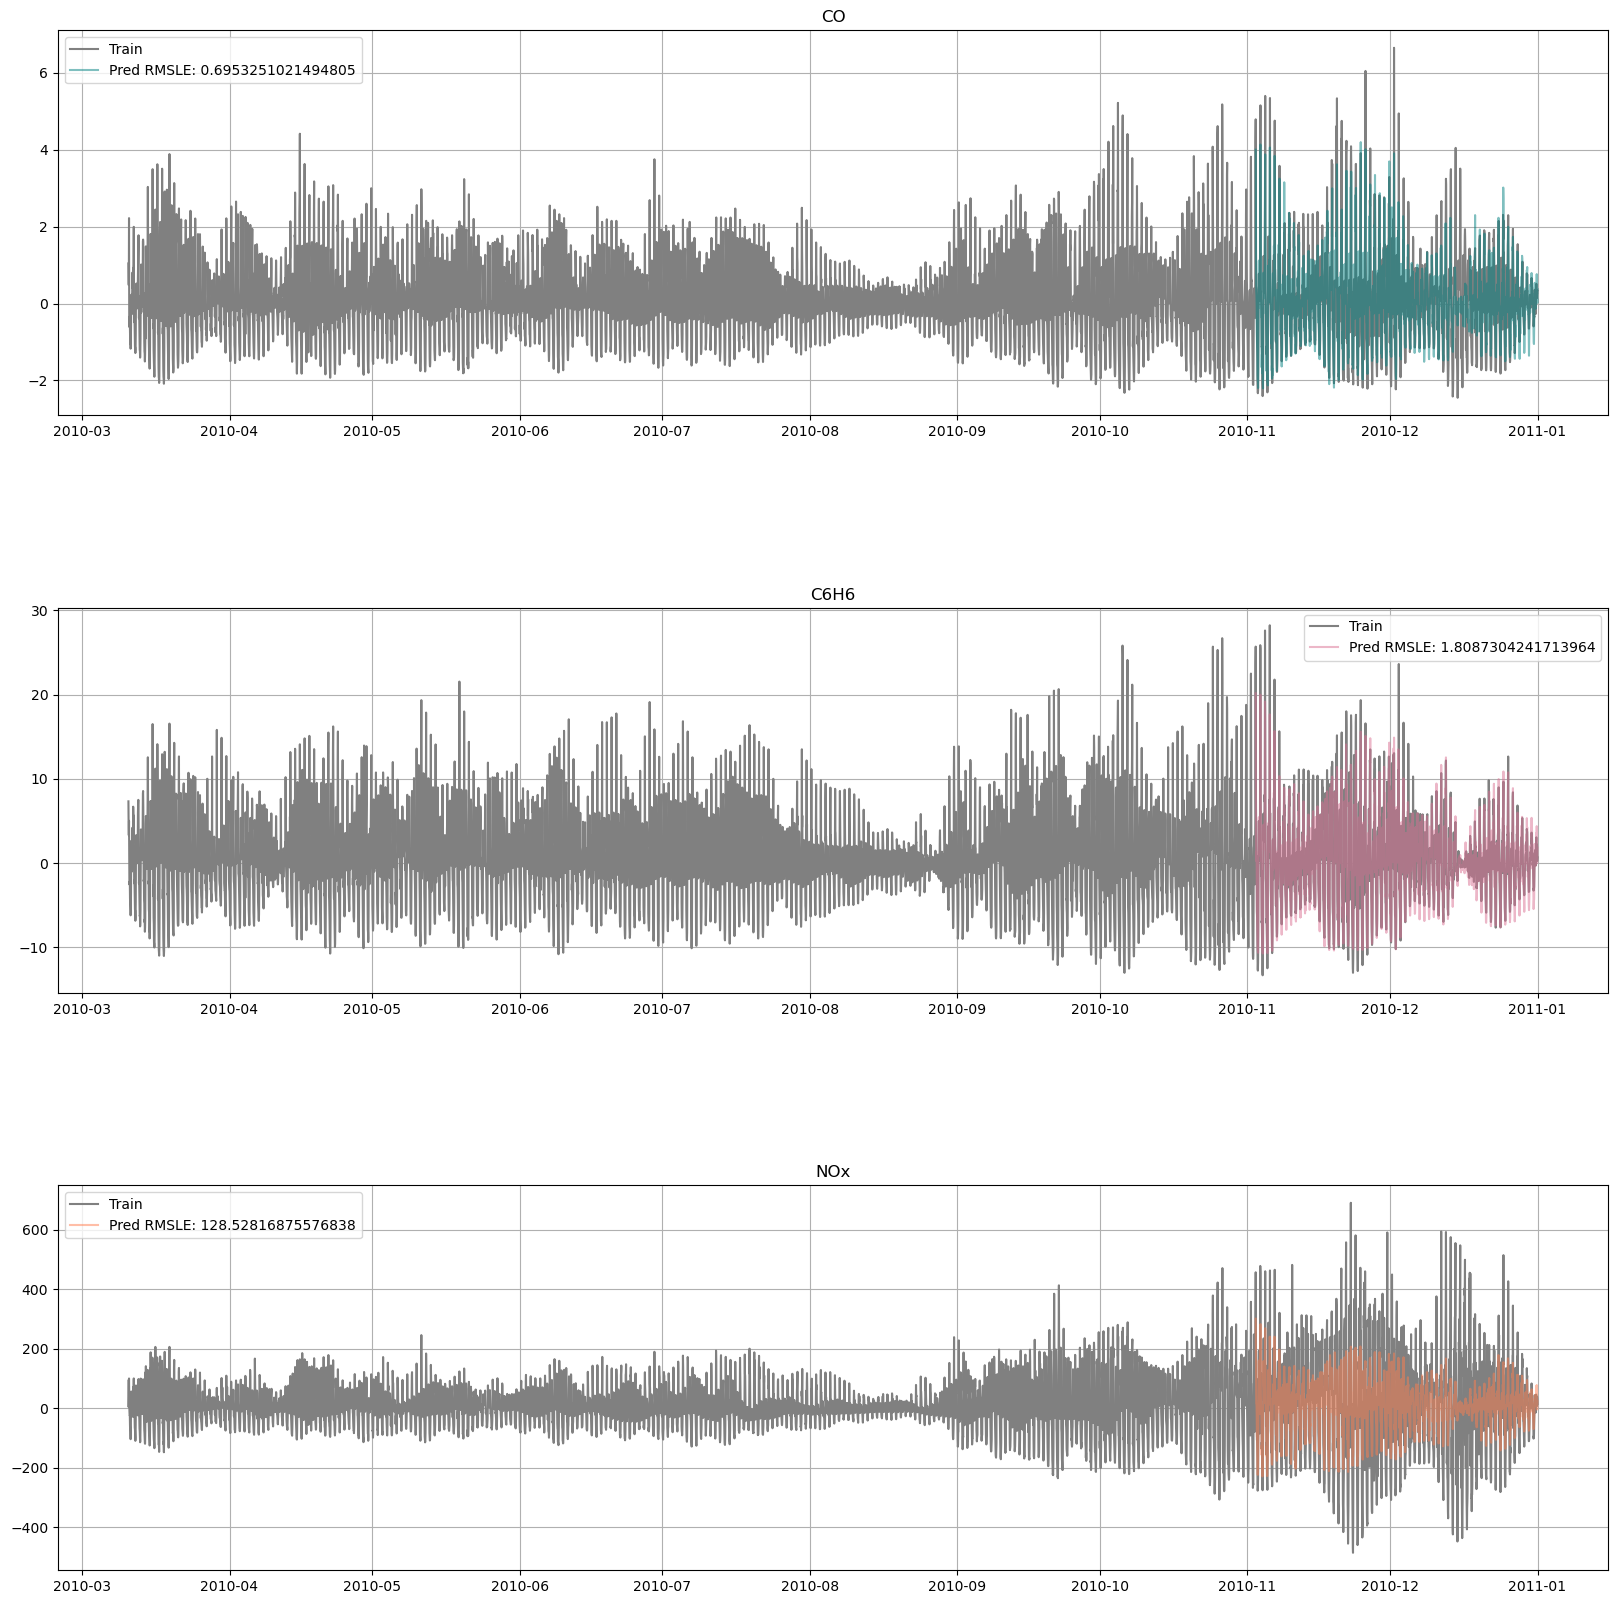

In [ ]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)


for i in range(3):

    name1 = f'val_lgb_{target_names[i]}'
    name2 = f'rmse_{target_names[i]}'  

    axs[i].plot(df_seasonal['date_time'], df_seasonal[targets[i]], color='gray', label='Train')
    axs[i].plot(val_x_CO.index, globals()[name1], color=colors[i], alpha=0.5, label=f'Pred RMSLE: {globals()[name2]}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

##### C6H6の予測結果を説明変数に加えてlightGBMで予測したらどうだろう

In [ ]:
df = pd.read_csv('train_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)
df = format_date_time(df)

df_seasonal = df.copy()

df_seasonal = targets_stl(df_seasonal)
df_seasonal = features_stl(df_seasonal)

100%|██████████| 129/129 [01:00<00:00,  2.13it/s]


In [ ]:
df_seasonal_NOx = df_seasonal.drop([targets[1]], axis=1)

df_seasonal_NOx_train, df_seasonal_NOx_val = train_test_split(df_seasonal_NOx, test_size=0.2, shuffle=False)

df_seasonal_NOx_val[targets[0]] = val_lgb_CO


In [ ]:
df_seasonal_NOx_train.set_index('date_time', inplace=True)
df_seasonal_NOx_val.set_index('date_time', inplace=True)
train_y_NOx = df_seasonal_NOx_train[targets[2]]
train_x_NOx = df_seasonal_NOx_train.drop(targets[2], axis=1)
val_y_NOx = df_seasonal_NOx_val[targets[2]]
val_x_NOx = df_seasonal_NOx_val.drop(targets[2], axis=1)

In [ ]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_NOx, train_y_NOx)
    lgb_valids = lgb.Dataset(val_x_NOx, val_y_NOx)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_NOx = regressor.predict(val_x_NOx)

    val_rmse = rmse(val_y_NOx, lgb_pred_val_y_NOx)
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=300)

In [ ]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(train_x_NOx, train_y_NOx)
valids = lgb.Dataset(val_x_NOx, val_y_NOx)

model_lgb_NOx = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_withCO_NOx = model_lgb_NOx.predict(val_x_NOx)
rmse_withCO_NOx = rmse(val_y_NOx, val_lgb_withCO_NOx)

rmse_withCO_NOx

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 0.009177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

128.44153047541613

結果：大して変わらず

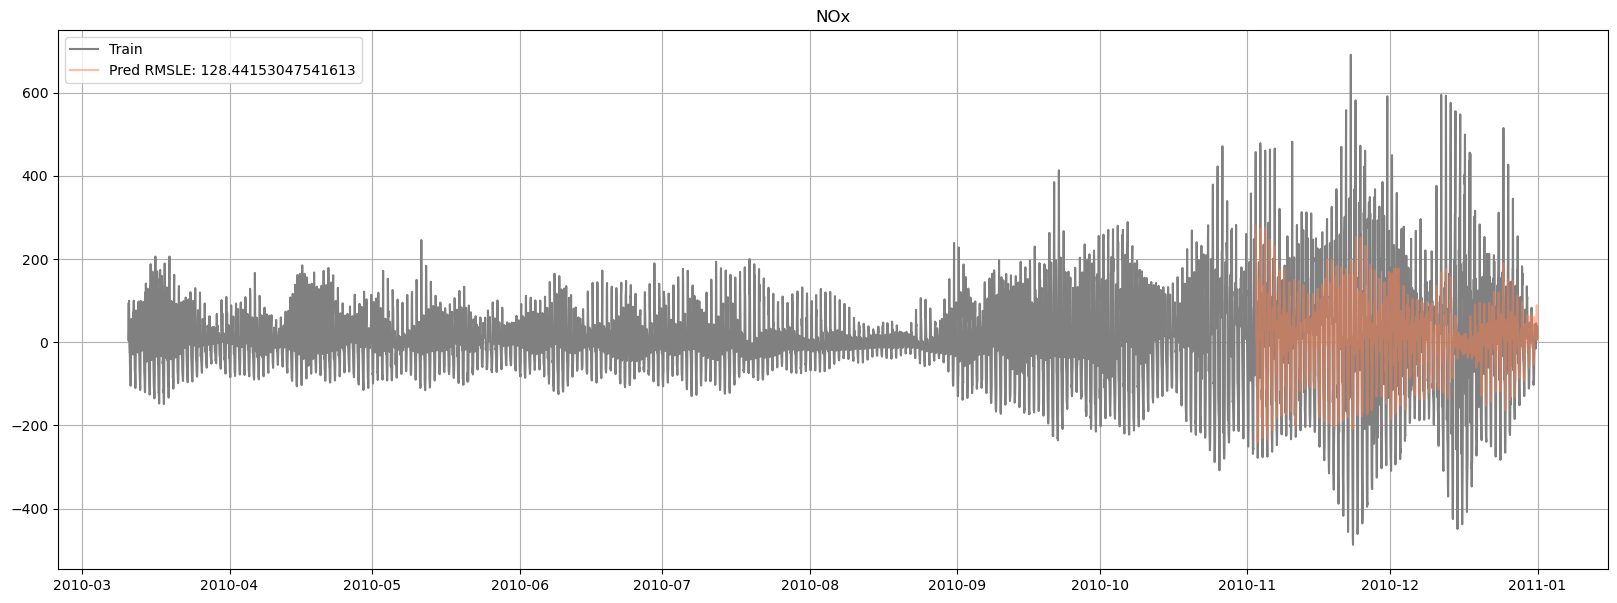

In [ ]:
fig, axs = plt.subplots(figsize=(20, 7), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

axs.plot(df_seasonal['date_time'], df_seasonal[targets[2]], color='gray', label='Train')
axs.plot(val_x_CO.index, val_lgb_withCO_NOx, color=colors[2], alpha=0.5, label=f'Pred RMSLE: {rmse_withCO_NOx}')
axs.set_title(f'{target_names[2]}')
axs.grid(axis='both')
axs.legend()

plt.show()

### シーズナル予測の結論

lightGBMでやる

### 最終結果を得る

In [ ]:
df_test = features_stl(df_test)
df_test.set_index('date_time', inplace=True)

100%|██████████| 129/129 [00:19<00:00,  6.70it/s]


In [ ]:
df = pd.read_csv('train_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)

df_seasonal = df.copy()

df_seasonal = targets_stl(df_seasonal)
df_seasonal = features_stl(df_seasonal)

100%|██████████| 129/129 [01:00<00:00,  2.14it/s]


In [ ]:
df_seasonal_CO = df_seasonal.drop([targets[1], targets[2]], axis=1)
df_seasonal_C6H6 = df_seasonal.drop([targets[0], targets[2]], axis=1)
df_seasonal_NOx = df_seasonal.drop([targets[0], targets[1]], axis=1)

df_seasonal_CO.set_index('date_time', inplace=True)
df_seasonal_C6H6.set_index('date_time', inplace=True)
df_seasonal_NOx.set_index('date_time', inplace=True)

In [ ]:
df_seasonal_CO.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7111 entries, 2010-03-10 18:00:00 to 2011-01-01 00:00:00
Columns: 130 entries, deg_C to dew_point_min168
dtypes: float64(130)
memory usage: 7.1+ MB


In [ ]:
df_seasonal_CO_y = df_seasonal_CO[targets[0]]
df_seasonal_CO_x = df_seasonal_CO.drop([targets[0]], axis=1)

df_seasonal_C6H6_y = df_seasonal_C6H6[targets[1]]
df_seasonal_C6H6_x = df_seasonal_C6H6.drop([targets[1]], axis=1)

df_seasonal_NOx_y = df_seasonal_NOx[targets[2]]
df_seasonal_NOx_x = df_seasonal_NOx.drop([targets[2]], axis=1)

In [ ]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_seasonal_CO_x, df_seasonal_CO_y)

model_lgb_CO_final = lgb.train(study_CO.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_CO
                    )

pred_CO = model_lgb_CO_final.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [ ]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_seasonal_C6H6_x, df_seasonal_C6H6_y)

model_lgb_C6H6_final = lgb.train(study_C6H6.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_C6H6
                    )

pred_C6H6 = model_lgb_C6H6_final.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [ ]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_seasonal_NOx_x, df_seasonal_NOx_y)

model_lgb_NOx_final = lgb.train(study_NOx.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_NOx
                    )

pred_NOx = model_lgb_NOx_final.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32385
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 127


In [ ]:
df_test = pd.read_csv('test_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)

df_test = format_date_time(df_test)

In [ ]:
df_seasonal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   seasonal_CO    2247 non-null   float64
 1   seasonal_C6H6  2247 non-null   float64
 2   seasonal_NOx   2247 non-null   float64
dtypes: float64(3)
memory usage: 52.8 KB


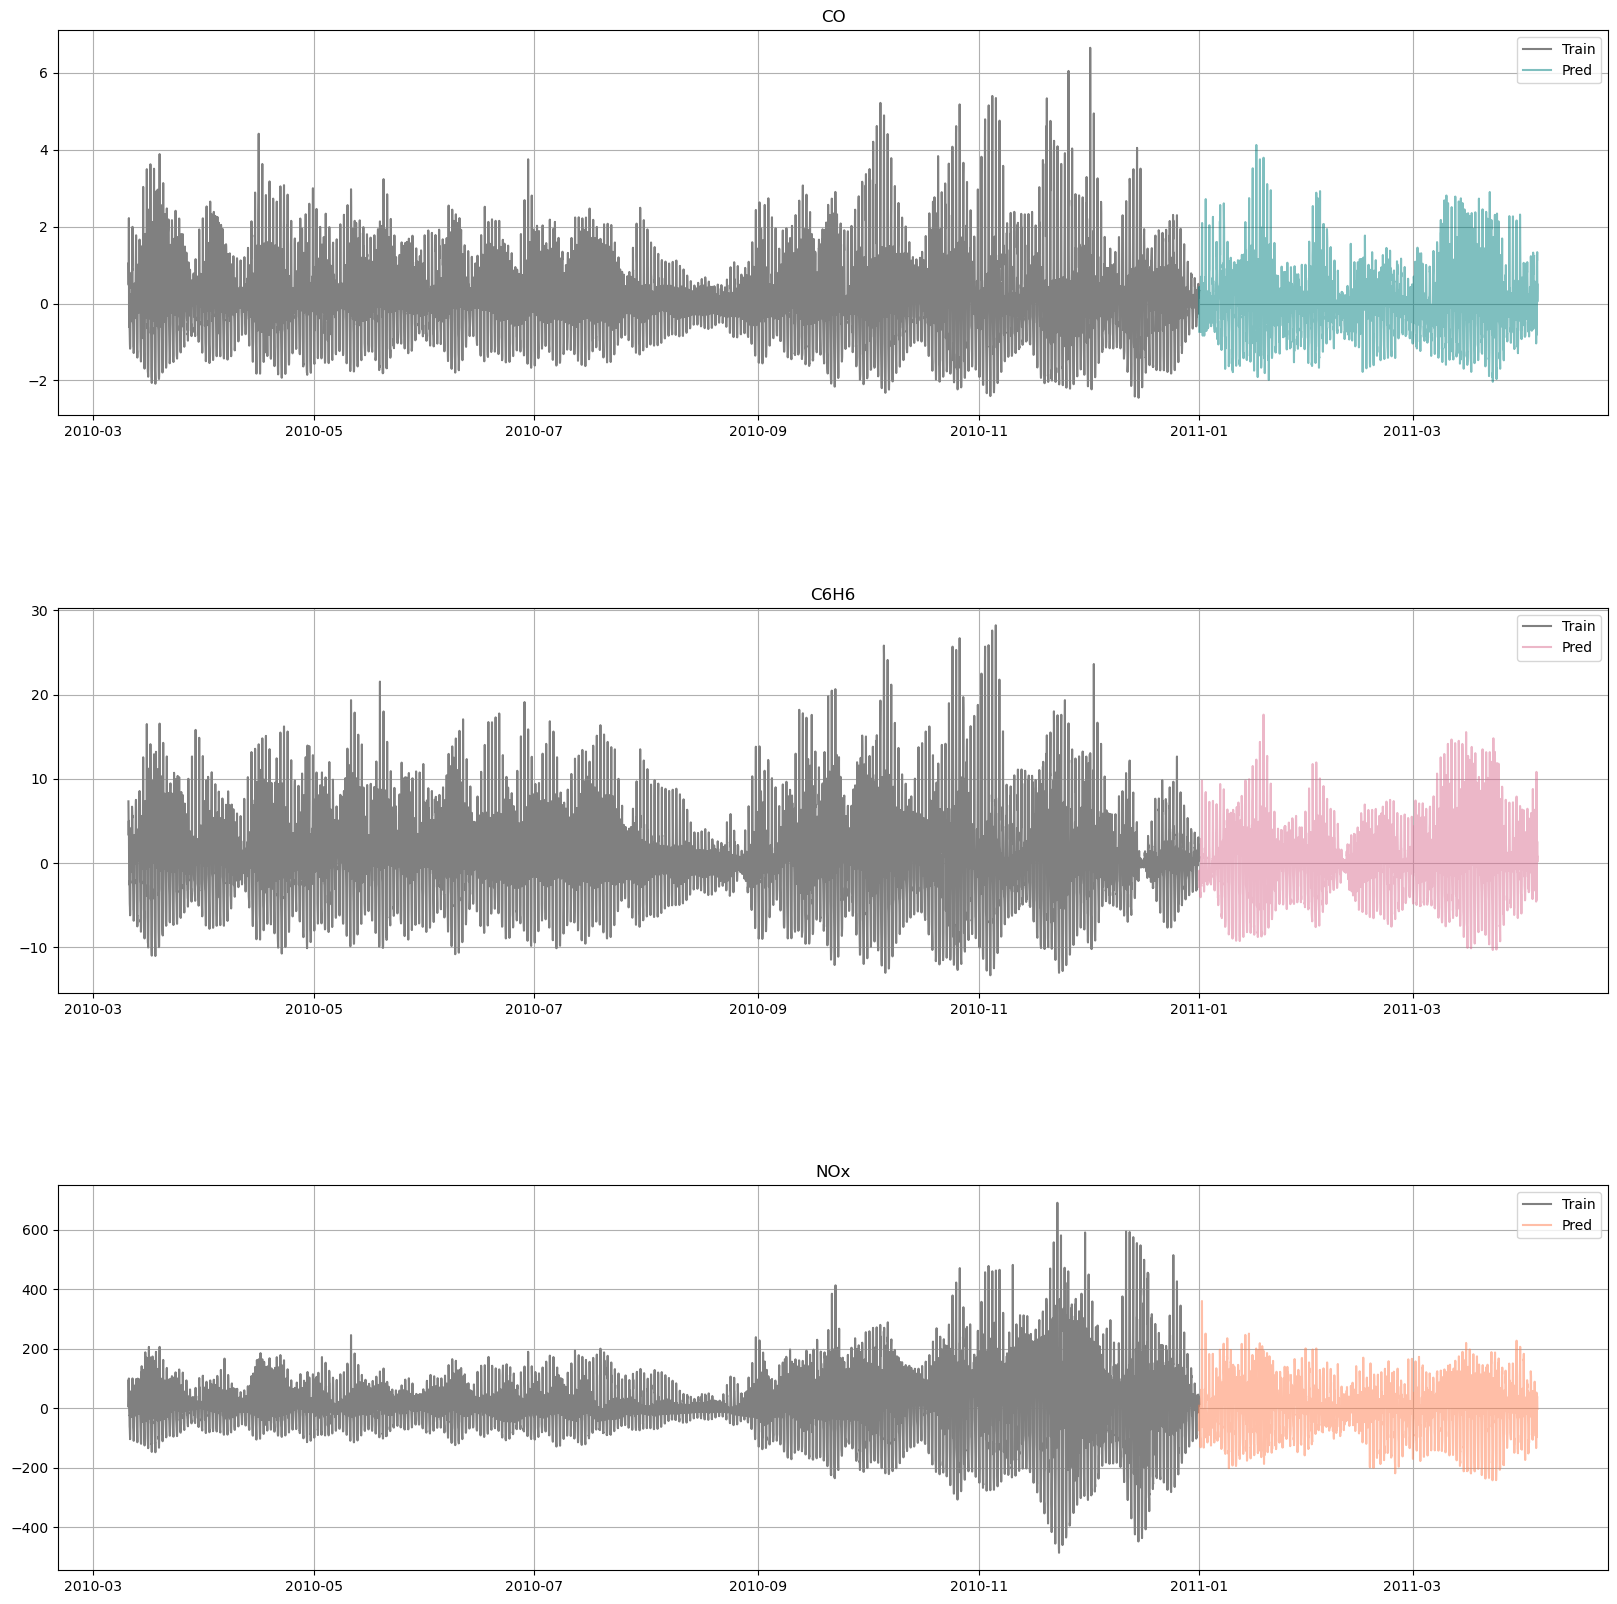

In [ ]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)


for i in range(3):

    name = f'pred_{target_names[i]}' 

    axs[i].plot(df_seasonal['date_time'], df_seasonal[targets[i]], color='gray', label='Train')
    axs[i].plot(df_test['date_time'], globals()[name], color=colors[i], alpha=0.5, label=f'Pred')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

##### 結果出力

In [ ]:
dt = df_test.index
cols = ['seasonal_CO', 'seasonal_C6H6', 'seasonal_NOx']

df_seasonal_pred = pd.DataFrame(index=dt, columns=cols)

df_seasonal_pred['seasonal_CO'] = pred_CO
df_seasonal_pred['seasonal_C6H6'] = pred_C6H6
df_seasonal_pred['seasonal_NOx'] = pred_NOx


In [ ]:
dt_val = val_x_CO.index
cols_val = ['val_seasonal_CO', 'val_seasonal_C6H6', 'val_seasonal_NOx']

df_seasonal_val = pd.DataFrame(index=dt_val, columns=cols_val)

df_seasonal_val['val_seasonal_CO'] = val_lgb_CO
df_seasonal_val['val_seasonal_C6H6'] = val_lgb_C6H6
df_seasonal_val['val_seasonal_NOx'] = val_lgb_NOx

In [ ]:
df_seasonal_val.astype('str')

In [ ]:
#df_seasonal_pred.to_csv('seasonal.csv', index=True)